# Burger's Equation

$$
\int_{\Omega} \frac{\partial u}{\partial t} + (u . \nabla) u - \nu \nabla^2 u dx = 0
$$

$$
\equiv \int_{\Omega} \frac{\partial u}{\partial t} . v + ((u . \nabla) u).v + \nu (\nabla u. \nabla v) dx = 0
$$


In [1]:
from firedrake import *
from pyroteus import *
from pyroteus_adjoint import *
import matplotlib.pyplot as plt
%matplotlib inline


NU = 0.0001


def get_form(mesh_seq):
    def form(index, solutions):
        u, u_ = solutions["u"]
        P = mesh_seq.time_partition
        dt = Constant(P.timesteps[index])
        nu = Constant(NU)

        v = TestFunction(u.function_space())
        F = (
            inner((u - u_) / dt, v) * dx
            + inner(dot(u, nabla_grad(u)), v) * dx
            + nu * inner(grad(u), grad(v)) * dx
        )
        return F

    return form


def get_solver(mesh_seq):
    def solver(index, ic):
        function_space = mesh_seq.function_spaces["u"][index]
        u = Function(function_space)

        u_ = Function(function_space, name="u_old")
        u_.assign(ic["u"])

        # Define form
        F = mesh_seq.form(index, {"u": (u, u_)})

        # Time integrate from start to end
        P = mesh_seq.time_partition
        t_start, t_end = P.subintervals[index]
        dt = P.timesteps[index]
        t = t_start
        while t < t_end - 1e-5:
            solve(F == 0, u, ad_block_tag="u")
            u_.assign(u)
            t += dt
        return {"u": u}

    return solver


def get_function_spaces(mesh):
    return {"u": VectorFunctionSpace(mesh, "CG", 1), "f": FunctionSpace(mesh, "DG", 0)}


def get_initial_condition(mesh_seq):
    fs = mesh_seq.function_spaces["u"][0]
    x, y = SpatialCoordinate(mesh_seq[0])
    # An initial condition that propagates to both ends
    return {"u": interpolate(as_vector([sin(pi * (x - 0.5)), 0]), fs)}


def get_qoi(mesh_seq, solutions, i):
    def end_time_qoi():
        u = solutions["u"]
        # ds(2) is dy (ds, subdomain 2)
        return inner(u, u) * ds(2)

    return end_time_qoi


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
n = 32
fields = ["u"]
meshes = [
    UnitSquareMesh(n, n, diagonal="left"),
    UnitSquareMesh(n, n, diagonal="left"),
]
end_time = 0.5
dt = 1 / n
num_subintervals = len(meshes)
time_partition = TimePartition(
    end_time, num_subintervals, dt, fields, timesteps_per_export=2
)
mesh_seq = GoalOrientedMeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="end_time",
)
# solutions = mesh_seq.solve_forward()

In [3]:
# vmax, vmin = -np.inf, np.inf
# print(len(solutions['u']['forward']), len(solutions['u']['forward'][0]))
# for i, sol_i in enumerate(solutions['u']['forward']):
#     for j, sol_t in enumerate(solutions['u']['forward'][i]):
#         vmax = max(vmax, np.max(sol_t.dat.data))
#         vmin = min(vmin, np.min(sol_t.dat.data))
#         print(vmin)
# print(vmax, vmin)
# print(max(abs(vmax), abs(vmin)), -max(abs(vmax), abs(vmin)))
# Note this is plotting the magnitude!!!!!!!!!


# vmin, vmax = 0, 1
# figsize = (2 * len(solutions['u']['forward'][0]), 2 * len(solutions['u']['forward'][0]))
# # print(figsize)
# fig, axes, tcs = plot_snapshots(solutions, time_partition, "u", "forward",
#                                 levels=np.linspace(0, 1, 100), cmap='viridis',
#                                 vmax=1, vmin=0, 
#                                 figsize=figsize)
# cbar = fig.colorbar(tcs[0][0], ax=axes, location='top')
# Note this is plotting the magnitude

NameError: name 'solutions' is not defined

In [ ]:
# solutions = mesh_seq.solve_adjoint()

In [ ]:
# print("QOI: {}".format(mesh_seq.get_qoi()))
# vmax, vmin = -np.inf, np.inf
# print(len(solutions['u']['adjoint']), len(solutions['u']['adjoint'][0]))
# for i, sol_i in enumerate(solutions['u']['adjoint']):
#     for j, sol_t in enumerate(solutions['u']['adjoint'][i]):
#         vmax = max(vmax, np.max(sol_t.dat.data))
#         vmin = min(vmin, np.min(sol_t.dat.data))
# Note this is plotting the magnitude!!!!!!!!!!!!!


# vmin = 0
# vmax = 1.25
# fig, axes, tcs = plot_snapshots(
#     solutions, time_partition, "u", "adjoint", levels=np.linspace(vmin, vmax, 100),
#     vmin=vmin, vmax=vmax,
#     cmap='viridis', figsize=figsize
# )
# cbar = fig.colorbar(tcs[-1][-1], ax=axes, location='top')

In [3]:
solutions, indicators = mesh_seq.indicate_errors(
    enrichment_kwargs={"enrichment_method": "p"}
)

In [5]:
# print(len(indicators[0]))
# print(type(indicators))
# print(len(indicators))
# print(indicators[0][0].dat.data.shape)
# print(mesh_seq[0].num_cells())
# print(np.max(np.abs(indicators[0][3].dat.data)))
# print(np.min(np.abs(indicators[0][3].dat.data)))
# print("Machine epsilon for np.float32: {}".format(np.finfo(np.float32).eps))

4
<class 'list'>
2
(2048,)
2048
1.0867856883093139e-07
1.4133694584505617e-21
Machine epsilon for np.float32: 1.1920928955078125e-07


In [6]:
# def plot_indicator_snapshots2(indicators, time_partition, **kwargs):
#     """
#     Plot a sequence of snapshots associated with
#     ``indicators`` and :class:`TimePartition`
#     ``time_partition``.

#     Any keyword arguments are passed to ``tricontourf``.

#     :arg indicators: list of list of indicators,
#         indexed by mesh sequence index, then timestep
#     :arg time_partition: the :class:`TimePartition`
#         object used to solve the problem
#     """
#     P = time_partition
#     rows = P.exports_per_subinterval[0] - 1
#     cols = P.num_subintervals
#     steady = rows == cols == 1
#     figsize = kwargs.pop("figsize", (6 * cols, 24 // cols))
#     fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
#     tcs = []
#     for i, indi_step in enumerate(indicators):
#         ax = axes if steady else axes[0] if cols == 1 else axes[0, i]
#         ax.set_title(f"Mesh[{i}]")
#         tc = []
#         for j, indi in enumerate(indi_step):
#             ax = axes if steady else axes[j] if cols == 1 else axes[j, i]
#             tc.append(tricontourf(indi, axes=ax, **kwargs))
#             if not steady:
#                 time = i * P.end_time/cols + j * P.timesteps_per_export[i] * P.timesteps[i]
#                 ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
#         tcs.append(tc)
#     plt.tight_layout()
#     return fig, axes, tcs

# # vmax, vmin = -np.inf, np.inf
# # for i, mesh_i in enumerate(indicators):
# #     for j, e_t in enumerate(indicators[i]):
# #         vmax = np.max((vmax, np.max(np.abs(e_t.dat.data))))
# #         vmin = np.min((vmin, np.min(np.abs(e_t.dat.data))))

# # print(vmax, vmin)
# vmax = 1e-6
# vmin = 0
# # We've switched over to a diverging colourmap, so for the bounds of our colourmap,
# # we want the center of the range to be 0, so we go from 
# # (vmax, vmin) to (-max(abs(vmax), abs(vmin)), max(abs(vmax), abs(vmin)))
# fig, axs, tcs = plot_indicator_snapshots2(indicators, time_partition, 
#                                           levels=np.linspace(vmin, vmax, 100), 
#                                           vmax=vmax, vmin=vmin, 
#                                           cmap='viridis',
#                                           figsize=figsize)
# cbar = fig.colorbar(tcs[1][-3], ax=axs, location='top')

NameError: name 'figsize' is not defined

-15.173946866914774 -63.9233663865523
2.0718377657208856e-11 8.315287191035679e-07


Text(0.5, 0.98, 'log DWR')

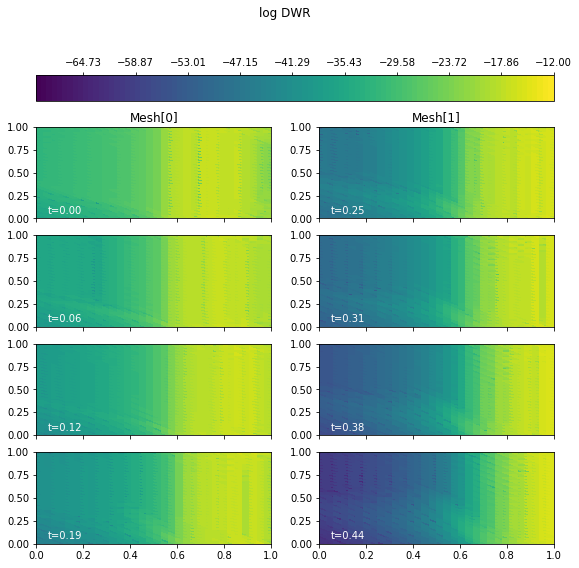

In [4]:
def plot_indicator_snapshots2(indicators, time_partition, **kwargs):
    """
    Plot a sequence of snapshots associated with
    ``indicators`` and :class:`TimePartition`
    ``time_partition``. This modification plots the log of errors.

    Any keyword arguments are passed to ``tricontourf``.

    :arg indicators: list of list of indicators,
        indexed by mesh sequence index, then timestep
    :arg time_partition: the :class:`TimePartition`
        object used to solve the problem
    """
    P = time_partition
    rows = P.exports_per_subinterval[0] - 1
    cols = P.num_subintervals
    steady = rows == cols == 1
    figsize = kwargs.pop("figsize", (6 * cols, 24 // cols))
    fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
    tcs = []
    for i, indi_step in enumerate(indicators):
        ax = axes if steady else axes[0] if cols == 1 else axes[0, i]
        ax.set_title(f"Mesh[{i}]")
        tc = []
        for j, indi in enumerate(indi_step):
            t_indi = Function(indi.function_space(), val=np.log(indi.dat.data))
            ax = axes if steady else axes[j] if cols == 1 else axes[j, i]
            tc.append(tricontourf(t_indi, axes=ax, **kwargs))
            if not steady:
                time = i * P.end_time/cols + j * P.timesteps_per_export[i] * P.timesteps[i]
                ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
        tcs.append(tc)
    plt.tight_layout()
    return fig, axes, tcs

vmax, vmin = -np.inf, np.inf
for i, mesh_i in enumerate(indicators):
    for j, e_t in enumerate(indicators[i]):
        vmax = np.max((vmax, np.max(np.log(np.abs(e_t.dat.data)))))
        vmin = np.min((vmin, np.min(np.log(np.abs(e_t.dat.data)))))

figsize = (2 * len(solutions['u']['forward'][0]), 2 * len(solutions['u']['forward'][0]))
print(vmax, vmin)
vmax = -12
vmin = -70
fig, axs, tcs = plot_indicator_snapshots2(indicators, time_partition, 
                                          levels=np.linspace(vmin, vmax, 100), 
                                          vmax=vmax, vmin=vmin, 
                                          cmap='viridis',
                                          figsize=figsize)
cbar = fig.colorbar(tcs[1][-3], ax=axs, location='top')
print(np.exp(-24.6), np.exp(-14))
plt.suptitle("log DWR")

In [8]:
# for field, sols in solutions.items():
#     fwd_outfile = File(f"test_burgers2/{field}_forward.pvd")
#     adj_outfile = File(f"test_burgers2/{field}_adjoint.pvd")
#     for i, mesh in enumerate(mesh_seq):
#         for sol in sols["forward"][i]:
#             fwd_outfile.write(sol)
#         for sol in sols["adjoint"][i]:
#             adj_outfile.write(sol)

## Error indicators to a monitor function to mesh adaptation

To create a scalar monitor function, we need 2 assumptions - 
1. The error indicators are a good approximation *
2. The local errors $\epsilon$ are proportional to the square of local grid-length parameter $l$, i.e. $\epsilon = c l^2$ for some scalar constant $c > 0$. 

don't think this (1) IS a good assumption because our error is so low to begin with - might have to change something
We have verified that our indicators are essentially a P0 function, i.e. one that varies per cell. We need to then create this monitor function using some sort of regression / interpolation to solve for the best-fit value of $c$? Also, importantly, we probably have to smooth this function somewhat. The mesh can become really deformed and lose overall quality if we don't. 

In Bauer et al. [2014] they assume $\epsilon_{\text{est}} = c l^2_{\text{est}}$ where $l_{\text{est}}$ is the grid-length of the uniform un-adapted grid. In our problem we are trying to distribute the error globally across cells. By making errors across all cells even, we will be enforcing that the grid-length of cells in the more error-prone regions of the domain decreases as compared to those in regions that do not affect the QOI. Thus, we can pick some target error, and solve for $l^2_{\text{target}}$ in each cell to adapt it. So, an implementation can go cell-by-cell, and move the vertex-coordinates globally to achieve the target edge-length but probably shouldn't. I assume we can use a metric space also to do this. In keeping with ensuring good mesh quality we can use constraints as described in Bauer [2014] but we probably want to re-examine this. 


To actually achieve the r-adaptation, the paper describes a method that solves for the monitor function $f(x)$, such that $\int_{\Omega} f(x) dA(x) = 1$, with $c = C_{\text{norm}} > 0$ and ensuring that other constraints are met (e.g. grid duality constraint - centroids must lie inside the original cell). Now, we represent $f$ as a transformation of all the grid points' coordinates. Since $f$ represents a ratio of the new area of each element to the old area, it's essentially describing a determinant of some transformation of these grid points. Based on existing literature, if we have $f > 0$ in $\Omega$ and $\int_{\Omega} (f(x)-1)dA(x) = 0$, then this transformation exists and is given by 

$$\text{det} \nabla \phi (x, y) = f(x, y) \text{  in  } \Omega $$
and 
$$\phi (x, y) = (x, y)  \text { on } \Gamma = \partial \Omega$$

Once we've got to this point, there's a clever way to calculate $\phi$ as a system of ODEs

In [9]:
# def plot_monitorfn_snapshots(monitor_fns, time_partition, **kwargs):
#     """
#     Plot a sequence of snapshots associated with
#     ``monitor_fns`` and :class:`TimePartition`
#     ``time_partition``.

#     Any keyword arguments are passed to ``tricontourf``.

#     :arg monitor_fns: list of list of monitor_fns,
#         indexed by mesh sequence index, then timestep
#     :arg time_partition: the :class:`TimePartition`
#         object used to solve the problem
#     """
#     P = time_partition
#     rows = 1
#     cols = P.num_subintervals
#     steady = rows == cols == 1
#     figsize = kwargs.pop("figsize", (6 * cols, 3 * cols))
#     fig, axes = plt.subplots(rows, cols, sharex="col", figsize=figsize)
#     tcs = []
#     for i, mesh_i in enumerate(monitor_fns):
#         ax = axes if steady else axes[0] if cols == 1 else axes[i]
#         ax.set_title(f"Mesh[{i}]")
#         tc = []
#         for j, fn in enumerate(monitor_fns[i]):
#             ax = axes if steady else axes[j] if cols == 1 else axes[i]
#             tc.append(tricontourf(fn, axes=ax, **kwargs))
# #             print(max(fn.dat.data))
#             if not steady:
#                 time = i * P.end_time/cols + j * P.timesteps_per_export[i] * P.timesteps[i]
#                 ax.annotate(f"t={time:.2f}", (0.05, 0.05), color="white")
#         tcs.append(tc)
#     plt.tight_layout()
#     return fig, axes, tcs

In [10]:
# print(len(solutions['u']['adjoint']))
# print(solutions['u']['adjoint'][0][0])

2
w_{84}


### Idea : Time dependence of errors

$$
\mathbf{F}(\xi) \text{ or } \mathbf{F}(\xi, t)
$$

In Bauer [2014], they make the error indicators time-independent by picking the maximum error in each cell across each time step. This makes sense for a single adapted mesh, and the idea can be extended in a pretty straightforward way for our case. This way we can make our monitor function for each mesh be constant and compute a transformation from it using a PDE. We could also allow time-dependence of our monitor function as per Budd [2009].

If we are to make the error indicators now time-independent per mesh, we can do this by just picking the maximum error indicator in each cell across all time-steps relevant to each mesh. This gives us a time-independent error indicator for each mesh. The type of QOI (end-time or time-integrated) does not really impact this (I think). Below this is some code that picks the maximum error indicator for each cell in the mesh's assigned subinterval and plots the aggregated, time-independent error indicators for both meshes. 

What do we _expect_ to see? Essentially some sort of convolution / average of the earlier plots for the adjoints and error indicators. This is because the errors are weighted by the magnitude of the adjoint solution. For the second mesh, for the most part both non-zero regions of the adjoint and error indicators are towards the right boundary. However, from the plots, just before we swap meshes, there are non-zero error indicators toward the right boundary (even though adjoint weights are mostly around 0 there). Thus, the first mesh would have maximum errors from the center all the way to the right edge with varying magnitudes.

1.3165219671673674e-07 5.2670472865595586e-17
2.570624290612981e-07 2.165142536983649e-23


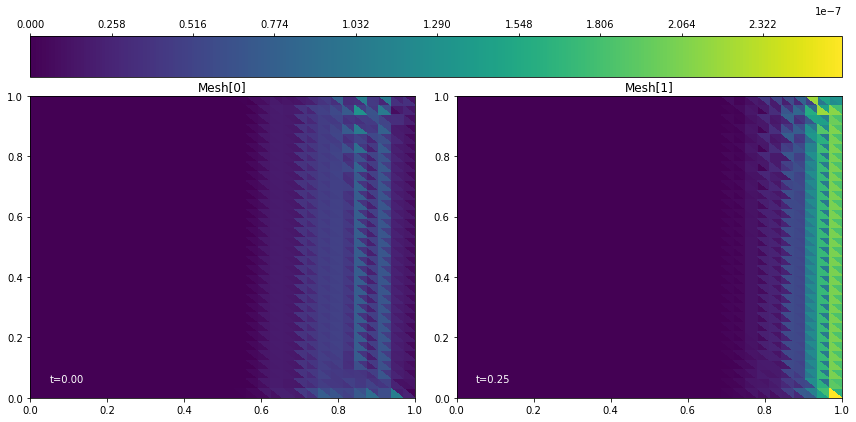

In [11]:
P0 = indicators[0][0].function_space()
# For now, let's just plot max(errs)
monitor_fns = []
areas = [get_areas2d(mesh) for mesh in mesh_seq]
vmax, vmin = -np.inf, np.inf
for i, mesh_i in enumerate(indicators):
    area = areas[i]
    
    max_errs = np.zeros(indicators[i][0].dat.data.shape)
    for j, e_t in enumerate(indicators[i]):
        max_errs = np.maximum(max_errs, e_t.dat.data)
        
    vmax = np.max((vmax, np.max(max_errs)))
    vmin = np.min((vmin, np.min(max_errs)))
    print(np.max(max_errs), np.min(max_errs))
#     print(max_errs)
#     print(1/max_errs)
    monitor_fn = Function(P0, val=max_errs)
    monitor_fns.append([monitor_fn])

test = monitor_fns[0][0]
# print(test.dat.data.shape)
# print(test.function_space)
fig, axs, tcs = plot_monitorfn_snapshots(monitor_fns, time_partition, 
                                         levels=1000, cmap='viridis',
                                         vmax=max(abs(vmax), abs(vmin)),
                                         vmin=0)
cbar = fig.colorbar(tcs[-1][-1], ax=axs, location='top')

### Bounding the monitor function

As per Bauer (2014), we must bound the monitor function to satisfy the grid duality constraint. We define a refinement level, 
$$\gamma \equiv \frac{dA(x) }{ \text{min}_{x\in\Omega} dA'(x)}$$
which dictates the minimum cell-size we can refine to. We can also define an error bound $\eta_{b}$ and an area function $b(\eta_{b})$ such that 
$$b(\eta_b) = A(\eta_{b}) / A_{\Omega}$$
i.e. the ratio of the area of the smallest adapted cell to the area of the domain. We can bound our error indicators $\eta(\mathbf{x})$ as 

$$
f(\mathbf{x}) = C_{\text{norm}} .
\begin{cases}
1/\eta_{b} & \text{ for } \eta(\mathbf{x}) > \eta_{b}\\
1/\eta(\mathbf{x}) & \text{ for } \eta_{b} < \eta(\mathbf{x}) < \eta_{b} / \gamma\\
\gamma/\eta_{b} & \text{ for } \eta(\mathbf{x}) < \eta_{b} / \gamma \\
\end{cases}
$$

(2048,)
366 405 3325
16.811242831518264 17.50439001207821
20000000.0 40000000.0


Text(0.5, 0.98, 'Log of bounded monitor function')

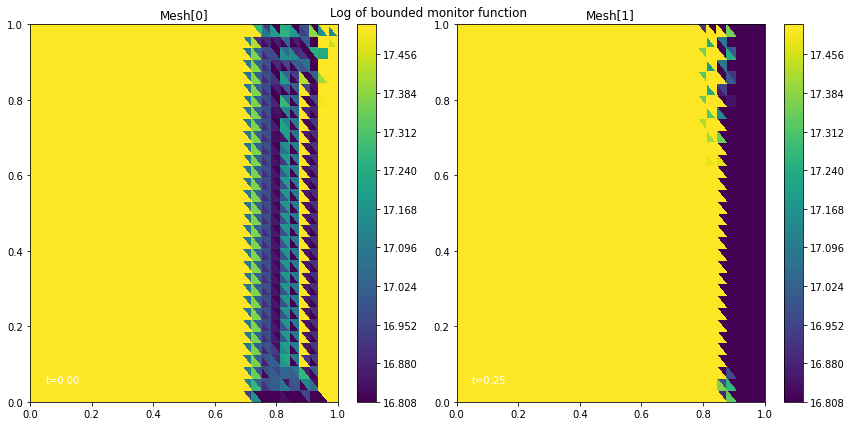

In [12]:
gamma = 2 # Refinement level
print(max_errs.shape)
eta_b = 5e-8 # error bound (dunno really what's a good value here)
bounded_errs = np.zeros(max_errs.shape)
bounded_fns = []
errs_bound_fns = []
c_norm = 1
abv_cnt, mid_cnt, bel_cnt = 0, 0, 0
for i, fn_l in enumerate(monitor_fns):
    fn = fn_l[0]
    for j in range(fn.dat.data.shape[0]):
        if fn.dat.data[j] > eta_b:
            bounded_errs[j] = 1 / eta_b
            abv_cnt += 1
        elif eta_b / gamma < fn.dat.data[j] < eta_b:
            bounded_errs[j] = 1 / fn.dat.data[j]
            mid_cnt += 1
        else:
            bounded_errs[j] = gamma / eta_b
            bel_cnt += 1
    bounded_fn = Function(P0, val=np.log(bounded_errs))
    bounded_fns.append([bounded_fn])
    errs_bound_fn = Function(P0, val=1/bounded_errs)
    errs_bound_fns.append([errs_bound_fn])
print(abv_cnt, mid_cnt, bel_cnt)
vmin = np.log(1 / eta_b)
vmax = np.log(gamma / eta_b)
print(vmin, vmax)
print(1 / eta_b, gamma / eta_b)
fig, axs, tcs = plot_monitorfn_snapshots(bounded_fns, time_partition, 
                                         levels=100,
                                         vmin=vmin, vmax=vmax,
                                         cmap='viridis')
cbar1 = fig.colorbar(tcs[0][0], ax=axs[0])
cbar = fig.colorbar(tcs[-1][-1], ax=axs[1])
# fig.title("log of bounded function")
plt.suptitle("Log of bounded monitor function")

### Smoothing of the monitor function

Given that we still see relatively large jumps in the value of the monitor function, directly applying $r$-adaptation to the mesh can create meshes of poor quality. To avoid doing this, we also have to smooth the monitor function. Bauer et al.(2014) describe a two-step approach to smoothing the monitor function, comprising
1. Replacing the monitor function of a cell $\mathbf{x}$ with the minimum of the bounded function in a neighbourhood of size $d$ from the cell, i.e.
$$f_{\text{ext}} (\mathbf{x}) := \text{min}_{\substack{\mathbf{x}' \in U_d(\mathbf{x})}} f(\mathbf{x}')$$
where $U_d(\mathbf{x}) = \{ \mathbf{x}' \in \Omega\; \big|\; |\mathbf{x}' - \mathbf{x}| \leq d\}$
2. Convolving the extended function with a Gauss function, i.e.
$$f_{\text{sm}}(\mathbf{x}) =  \frac{1}{c_{\text{sm}}}  \int_{\Omega} f_{\text{ext}} (\mathbf{x}')\text{exp}(-|\mathbf{x}' - \mathbf{x}|_{s}^2/d^2) d\mathbf{x}'$$
$$c_{\text{sm}} = \int_{\Omega} \text{exp}(-|\mathbf{x}'|_s / d^2) d\mathbf{x}'$$

### Alternative method for smoothing

Based on [this](https://eartharxiv.org/repository/view/1751/) paper, we can instead use laplacian smoothing techniques, essentially 

$$
\frac{f_{\text{smooth}}(\mathbf{x}) - f_{\text{bound}}(\mathbf{x})}{\Delta t} = 
K \nabla^2 f_{\text{smooth}}(\mathbf{x})
$$
where 
$$
K = N \frac{\Delta x^2}{4 \Delta t}
$$


where $N$ is the number of applications of a laplacian filter.

For this we have monitor function proportional to errors, so things are flipped compared to the previous plot.

In weak form 
$$
\int_\Omega \left(v.\frac{f_{\text{smooth}} - f_{\text{bound}}}{\Delta t} -
v.K \nabla^2 f_{\text{smooth}}\right) dx = 0
$$
$$
\implies \int_\Omega \left( (f_{\text{smooth}} - f_{\text{bound}}).v -
(N \Delta x^2) (\nabla^2 f_{\text{smooth}}).v \right) dx = 0
$$


2
4


Text(0.5, 0.98, 'Bounded monitor function')

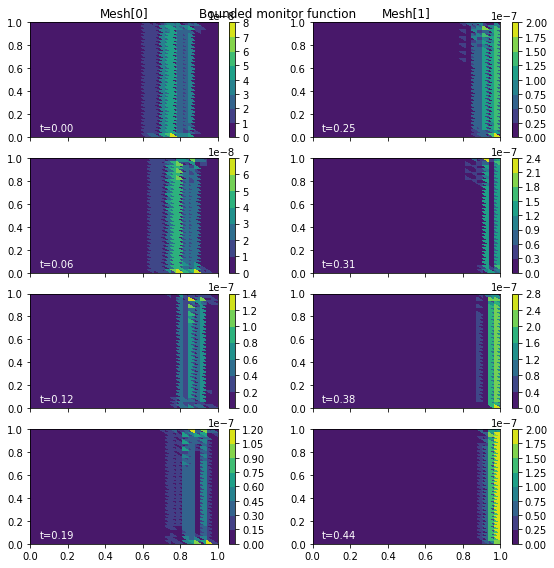

In [5]:
# First step, extract f as time-dependent

# We might also want to bound it, not going to use this just yet
gamma = 2 # Refinement level
eta_b = 5e-8
funcs = []
P0 = indicators[i][0].function_space()
for i, mesh_i in enumerate(indicators):
#     area = areas[i]
    
    max_errs = np.zeros(indicators[i][0].dat.data.shape)
    fns = []
    for j, e_t in enumerate(indicators[i]):
        val = np.array(e_t.dat.data)
        fn = Function(P0, val=val)
        fns.append(fn)
    funcs.append(fns)
print(len(funcs))
print(len(funcs[1]))
fig, axs, tcs = plot_indicator_snapshots(funcs, time_partition, cmap='viridis', figsize=figsize)
# cbar = fig.colorbar(tcs[-1][-1], ax=axs, location='top')
# plt.suptitle("Monitor function")
for i in range(axs.shape[1]):
    for j in range(axs.shape[0]):
        fig.colorbar(tcs[i][j], ax=axs[j, i])
plt.suptitle("Bounded monitor function")

In [ ]:
# fig, axs, tcs = plot_monitorfn_snapshots(errs_bound_fns, time_partition, 
#                                          vmin=5e-9, vmax=5e-8,
#                                          cmap='viridis')
# cbar1 = fig.colorbar(tcs[0][0], ax=axs[0])
# cbar = fig.colorbar(tcs[-1][-1], ax=axs[1])
# # fig.title("log of bounded function")
# plt.suptitle("Log of bounded error function")

$$
\int_\Omega \left( \frac{(f_{\text{smooth}} - f_{\text{bound}}}{\Delta t}).v -
K (\nabla^2 f_{\text{smooth}}).v \right) dx = 0
$$

In [14]:
N = 40     # Just taking the value from the paper
# j = 0
smoothed_fns = []
P = mesh_seq.time_partition
num_smooth = 4
for i in range(len(funcs)):
#     print(i)
    fns = []
    function_space = funcs[i][0].function_space()
    dt = P.timesteps[i]
    delX = Constant(1 / (2 * n))
    K = Constant(N * delX**2/ dt)
    t_start, t_end = P.subintervals[i]
    f_bound = Function(function_space)
    f_smooth = Function(function_space)
    v = TestFunction(f_bound.function_space())
    F = (inner((f_smooth - f_bound)/dt, v) * dx - K * inner(div(grad(f_smooth)), v) * dx)
#         - (K * inner(dot(grad(f_smooth), FacetNormal(meshes[i])), v)
    fns = [fn.copy(deepcopy=True) for fn in funcs[i]]
    for k in range(num_smooth):
        print('\n')
        t = t_start
        for j in range(len(funcs[i])): # this should be the same as while t < t_end - 1e-5:
            f_bound.assign(fns[j])
            solve(F == 0, f_smooth)
            t += dt
            fns[j].assign(f_smooth)
#             print(np.max(f_smooth.dat.data), np.min(f_smooth.dat.data))
    smoothed_fns.append(fns)

# print(len(smoothed_fns), len(smoothed_fns[0]), type(smoothed_fns[0][0]))
# print(np.min(smoothed_fns[-1][-1].dat.data), np.max(smoothed_fns[-1][-1].dat.data))

UFL:ERROR This integral is missing an integration domain.


UFLException: This integral is missing an integration domain.

Text(0.5, 0.98, '(4x Smooth) Monitor Function')

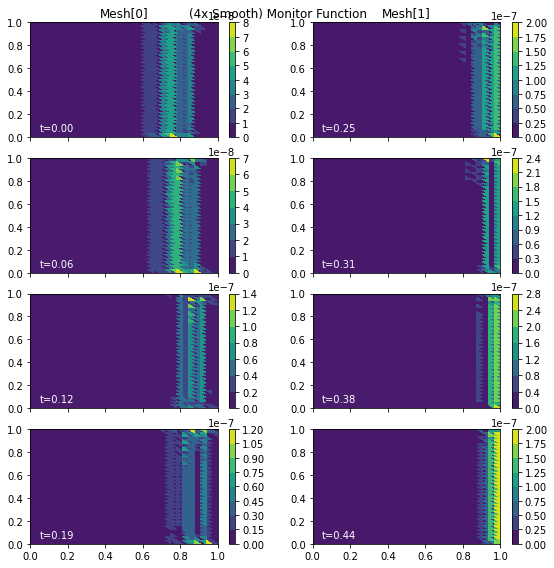

In [10]:
fig, axs, tcs = plot_indicator_snapshots(smoothed_fns, time_partition, cmap='viridis', figsize=figsize)
# ,
#                                         vmin=0.0000, vmax=0.01, levels=np.linspace(0, 0.01, 100))
# print(len(tcs[0]))
# print(axs.shape)
for i in range(axs.shape[1]):
    for j in range(axs.shape[0]):
        fig.colorbar(tcs[i][j], ax=axs[j, i])
# cbar = fig.colorbar(tcs[1][-3], ax=axs, location='top')
plt.suptitle("({}x Smooth) Monitor Function".format(num_smooth))

(4, 2)


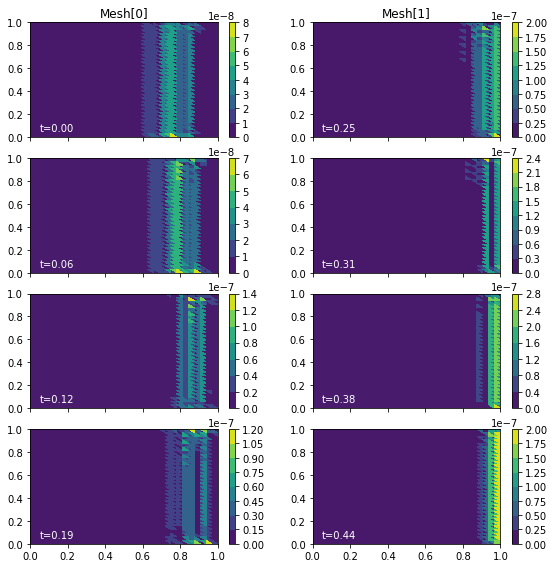

In [63]:
fig, axs, tcs = plot_indicator_snapshots(funcs, time_partition, cmap='viridis', figsize=figsize)
print(axs.shape)
for i in range(axs.shape[1]):
    for j in range(axs.shape[0]):
        fig.colorbar(tcs[i][j], ax=axs[j, i])
